# Load GeoTiff file from a non-seachable STAC catalog

This notebook shows an example how to load a GeoTIFF file from a non-searchable STAC catalog. 

A non-searchable catalog does not implement the [STAC API - Item Search](https://github.com/radiantearth/stac-api-spec/tree/release/v1.0.0/item-search) conformance class. When searching in such type of catalog, the catalog needs to be crawled through and the items properties needs to be matched to the search parameters. This process can be slow, especially for large catalogs.

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../README.md).

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store, get_data_store_params_schema
import itertools

CPU times: user 2.96 s, sys: 234 ms, total: 3.19 s
Wall time: 1.25 s


First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). 

In [2]:
get_data_store_params_schema("stac")

We determine the url of the [EcoDataCube.eu](https://stac.ecodatacube.eu/) STAC catalog and initiate a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) where the `xcube-stac` plugin is recognized by setting the first argument to `"stac"` in the `new_data_store` function.

In [3]:
%%time
url = "https://s3.eu-central-1.wasabisys.com/stac/odse/catalog.json"
store = new_data_store("stac", url=url)

CPU times: user 20.9 ms, sys: 1.99 ms, total: 22.9 ms
Wall time: 332 ms


/home/konstantin/micromamba/envs/xcube-stac/lib/python3.12/site-packages/pystac_client/client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [4]:
%%time
data_ids = store.get_data_ids()
list(itertools.islice(data_ids, 10))

CPU times: user 966 ms, sys: 124 ms, total: 1.09 s
Wall time: 20.5 s


['lcv_land.mask_eumap/lcv_land.mask_eumap_2014.01.01..2016.12.31/lcv_land.mask_eumap_2014.01.01..2016.12.31.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_1999.12.02..2000.03.20/lcv_blue_landsat.glad.ard_1999.12.02..2000.03.20.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2000.03.21..2000.06.24/lcv_blue_landsat.glad.ard_2000.03.21..2000.06.24.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2000.06.25..2000.09.12/lcv_blue_landsat.glad.ard_2000.06.25..2000.09.12.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2000.09.13..2000.12.01/lcv_blue_landsat.glad.ard_2000.09.13..2000.12.01.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2000.12.02..2001.03.20/lcv_blue_landsat.glad.ard_2000.12.02..2001.03.20.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2001.03.21..2001.06.24/lcv_blue_landsat.glad.ard_2001.03.21..2001.06.24.json',
 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2001.06.25..2001.09.12/lcv_blue_l

In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [5]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 27 μs, sys: 3 μs, total: 30 μs
Wall time: 32.9 μs


Now, let's search for Landsat Thematic Mapper data for the European region during the first quarter of 2000.

In [6]:
%%time
descriptors = list(
    store.search_data(
        collections=["lcv_blue_landsat.glad.ard"],
        bbox=[-10, 40, 40, 70],
        time_range=["2000-01-01", "2000-04-01"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 297 ms, sys: 65.2 ms, total: 362 ms
Wall time: 10.6 s


[{'data_id': 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_1999.12.02..2000.03.20/lcv_blue_landsat.glad.ard_1999.12.02..2000.03.20.json',
  'data_type': 'dataset',
  'bbox': [-23.550818268711048,
   24.399543432891665,
   63.352379098951936,
   77.69295185585888],
  'time_range': ('1999-12-02', '2000-03-20')},
 {'data_id': 'lcv_blue_landsat.glad.ard/lcv_blue_landsat.glad.ard_2000.03.21..2000.06.24/lcv_blue_landsat.glad.ard_2000.03.21..2000.06.24.json',
  'data_type': 'dataset',
  'bbox': [-23.550818268711048,
   24.399543432891665,
   63.352379098951936,
   77.69295185585888],
  'time_range': ('2000-03-21', '2000-06-24')}]

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [7]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 86 μs, sys: 9 μs, total: 95 μs
Wall time: 97.5 μs


Now, we open the data for a given data ID, where we select all available assets, which can be opened by the data store. Note that we assign `data_type` to get an `xarray.Dataset` as return value. 

In [8]:
%%time
ds = store.open_data(descriptors[0].data_id, data_type="dataset")
ds

CPU times: user 4.22 s, sys: 219 ms, total: 4.44 s
Wall time: 6.11 s


<xarray.Dataset> Size: 114GB
Dimensions:      (x: 188000, y: 151000)
Coordinates:
  * x            (x) float64 2MB 9e+05 9e+05 9.001e+05 ... 6.54e+06 6.54e+06
  * y            (y) float64 1MB 5.46e+06 5.46e+06 ... 9.301e+05 9.3e+05
    spatial_ref  int64 8B 0
Data variables:
    blue_p50     (y, x) uint8 28GB dask.array<chunksize=(512, 512), meta=np.ndarray>
    blue_p25     (y, x) uint8 28GB dask.array<chunksize=(512, 512), meta=np.ndarray>
    blue_p75     (y, x) uint8 28GB dask.array<chunksize=(512, 512), meta=np.ndarray>
    qa_f         (y, x) uint8 28GB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    stac_catalog_url:  https://s3.eu-central-1.wasabisys.com/stac/odse/catalo...
    stac_item_id:      lcv_blue_landsat.glad.ard_1999.12.02..2000.03.20

We plot the loaded data as an example below.

CPU times: user 2.06 s, sys: 704 ms, total: 2.76 s
Wall time: 34.7 s


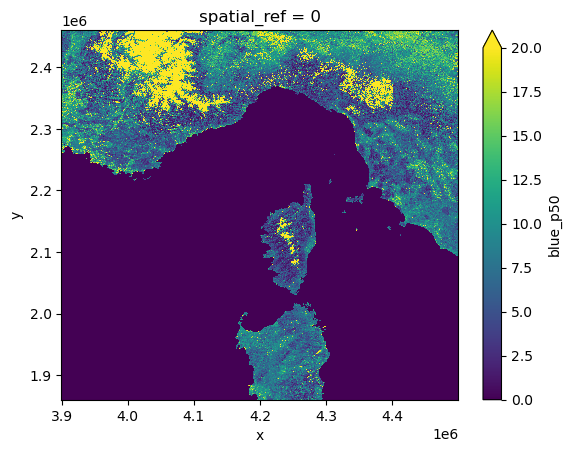

In [9]:
%%time
ds.blue_p50[100000:120000:20, 100000:120000:20].plot(vmax=20)

We can also open a GeoTIFF as a [xcube's multi-resolution  dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html#xcube-multi-resolution-datasets), where we can select the level of resolution, shown below.

In [10]:
%%time
mlds = store.open_data(descriptors[0].data_id, data_type="mldataset")
mlds.num_levels

CPU times: user 18.7 ms, sys: 3.23 ms, total: 21.9 ms
Wall time: 360 ms


9

In [11]:
ds = mlds.get_dataset(5)
ds

<xarray.Dataset> Size: 111MB
Dimensions:      (x: 5875, y: 4719)
Coordinates:
  * x            (x) float64 47kB 9.005e+05 9.014e+05 ... 6.539e+06 6.54e+06
  * y            (y) float64 38kB 5.46e+06 5.459e+06 ... 9.314e+05 9.305e+05
    spatial_ref  int64 8B 0
Data variables:
    blue_p50     (y, x) uint8 28MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    blue_p25     (y, x) uint8 28MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    blue_p75     (y, x) uint8 28MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    qa_f         (y, x) uint8 28MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    stac_catalog_url:  https://s3.eu-central-1.wasabisys.com/stac/odse/catalo...
    stac_item_id:      lcv_blue_landsat.glad.ard_1999.12.02..2000.03.20

CPU times: user 44.7 ms, sys: 1.04 ms, total: 45.7 ms
Wall time: 215 ms


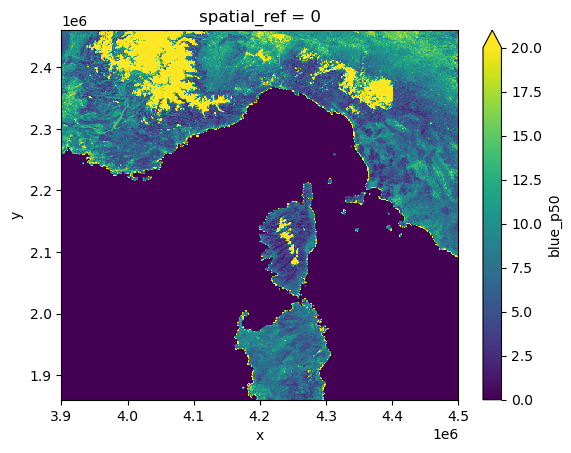

In [12]:
%%time
ds.blue_p50[3125:3750, 3125:3750].plot(vmax=20)